In [1]:
%matplotlib inline

## Import libraries

In [2]:
import pandas as pd
import os
import glob
import smopy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy import ndimage
from datetime import datetime
import imageio

In [ ]:
INPUT_FOLDER      = './data_preprocessed4/'

list_df_metadata = []

# Find all files that ends with .csv, read and append to the list_df_metadata
for filename in glob.glob(INPUT_FOLDER + '*.csv'):
    df_data = pd.read_csv(filename, parse_dates=['datetime', 'timedelta'])
    list_df_metadata.append(df_data)
    
df = pd.concat(list_df_metadata)
df = df.drop(['Unnamed: 0'], axis=1)
df = df.reset_index(drop=True)
df.head()

/home/xyz/Program/miniconda3/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_metadata.dtypes

## Plot the coordinates

In [11]:
smopy.TILE_SERVER = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png"
smopy.TILE_SIZE = 256

In [12]:
latMin = min(df.lat)
latMax = max(df.lat)
longMin = min(df.long)
longMax = max(df.long)

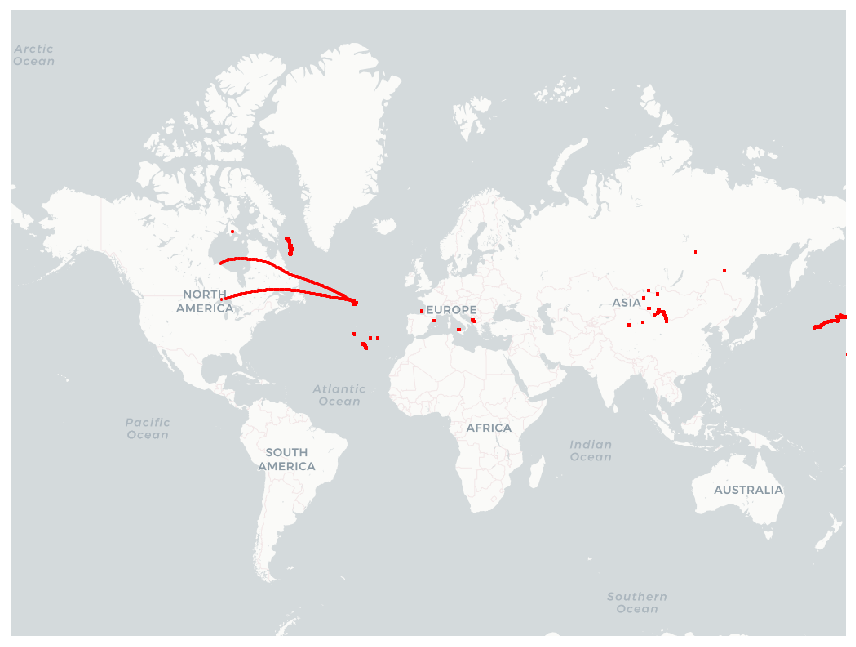

In [16]:
mapAll = smopy.Map((latMin, longMin, latMax, longMax ), z=2)
x, y = mapAll.to_pixels(df.lat, df.long)
ax = mapAll.show_mpl(figsize=(12, 10))
ax.plot(x, y, 'or', ms=2)

## Beijing

In [18]:
latMinB = 39.64
latMaxB = 40.51
longMinB = 115.76
longMaxB = 116.88

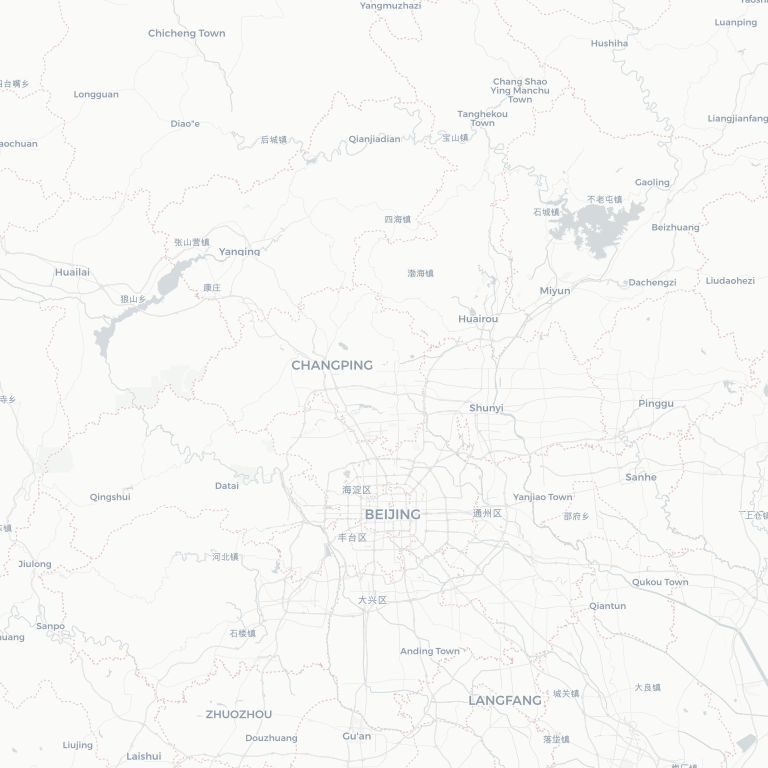

In [23]:
mapBeijing = smopy.Map((latMinB, longMinB, latMaxB, longMaxB ), z=9)
mapBeijing.show_ipython()

## Let's build a heatmap to check out the busy areas

In [24]:
df['xPixel'] = mapBeijing.to_pixels(df.lat, df.long)[0]
df['yPixel'] = mapBeijing.to_pixels(df.lat, df.long)[1]

In [27]:
# Filter data points
dfBeijing = df[(df.lat.between(latMinB, latMaxB)) & (df.long.between(longMinB, longMaxB))]

In [28]:
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, (1,0,0,0)), (0.5, (1,0.5,0,0.8)), (0.75, (1,1,0,0.8)), (0.875, (1,1,1,1)), (1, (1,1,1,1))])

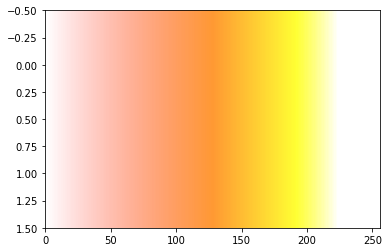

In [29]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots()
ax.imshow(gradient, aspect='auto', cmap=cmap)

/home/xyz/Program/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


8.148767783966829

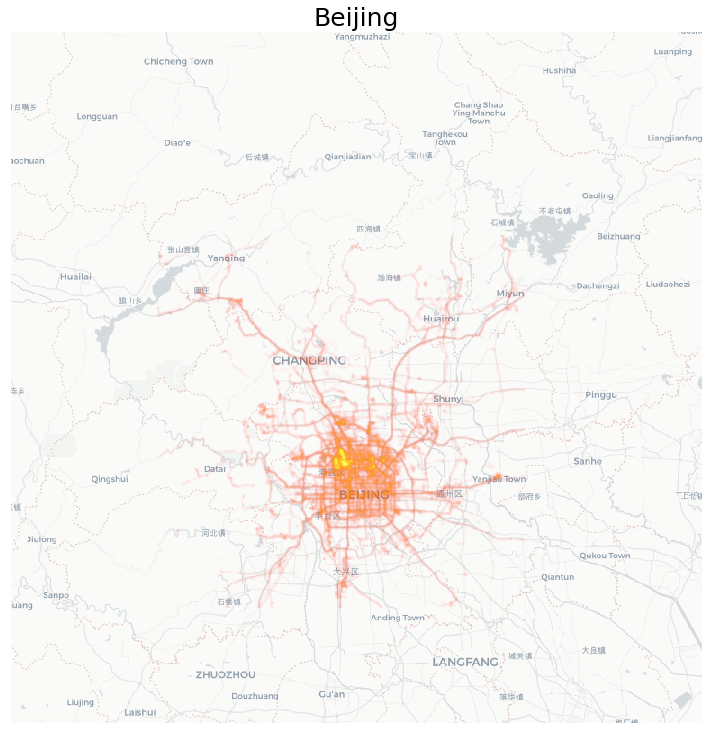

In [30]:
ax = mapBeijing.show_mpl(figsize=(12, 10))
bins=400
smoothing =1.

title = 'Beijing'

x = list(dfBeijing['xPixel'])
y = list(dfBeijing['yPixel'])
heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')

ax.set_title(title, size=25)

plt.savefig(title+'.png', bbox_inches='tight')
    
ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=10)

plt.savefig(title+'.png', bbox_inches='tight')

np.amax(logheatmap)

## Now that we figured out how to make a heatmap, let's put it into a function and zoom into the central area

In [31]:
def heatMap(long, lat, area, bins=200, smoothing=1, vmax=4, title=None):
    x = area.to_pixels(lat, long)[0]
    y = area.to_pixels(lat, long)[1]
    
    ax = area.show_mpl(figsize=(12, 10))
    
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    output = ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=vmax)
    
    if title:
        ax.set_title(title, size=25)
        plt.savefig(title+'.png', bbox_inches='tight')
    
    print(np.amax(logheatmap))
    return output

In [32]:
latMin = 39.8
latMax = 40
longMin = 116.2
longMax = 116.4

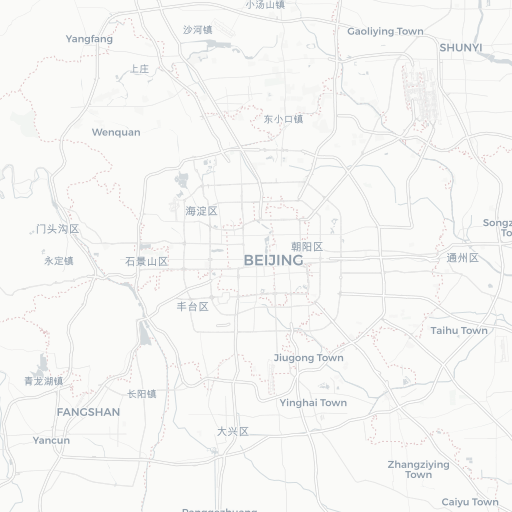

In [33]:
mapZoom = smopy.Map((latMin, longMin, latMax, longMax ), z=10)
mapZoom.show_ipython()

/home/xyz/Program/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


7.591056154563489


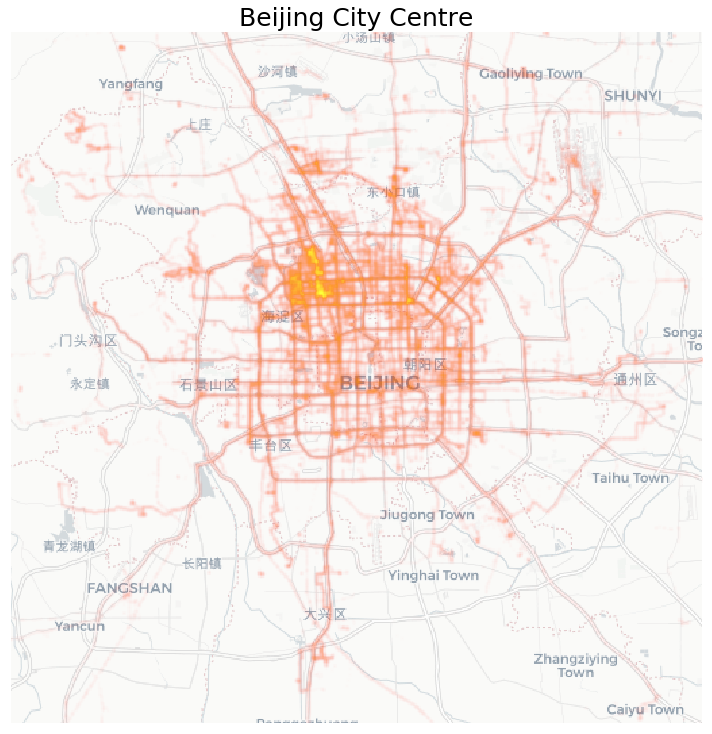

In [34]:
heatMap(dfBeijing.long, dfBeijing.lat, mapZoom, bins=800, vmax=10, title='Beijing City Centre')

In [35]:
## How many trajectories are there?


In [36]:
len(df.trajectory_id.unique())

16644

In [37]:
df.set_index('datetime', inplace=True)

CPU times: user 1.03 s, sys: 297 ms, total: 1.33 s
Wall time: 1.35 s


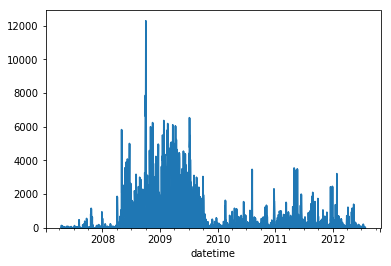

In [38]:
%time df.resample('D').count().lat.plot(kind='area')

## Check out the count of the labels

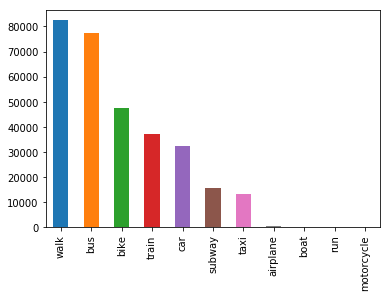

In [39]:
df['labels'].value_counts().plot(kind='bar')

## Find the busiest roads

In [41]:
dfRoads = dfBeijing[dfBeijing['labels'].isin(['car', 'bus', 'taxi'])]

/home/xyz/Program/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


4.515247647455473


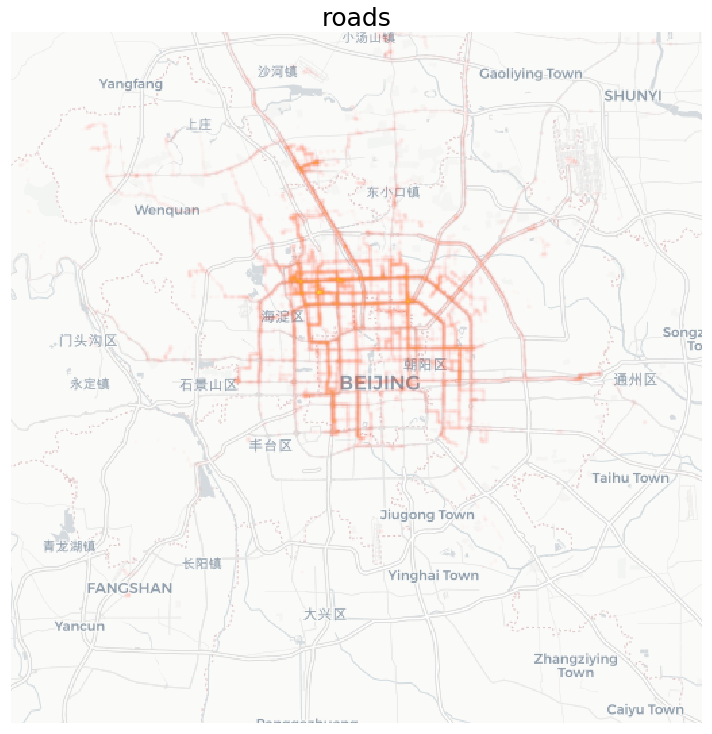

In [42]:
heatMap(dfRoads.long, dfRoads.lat, mapZoom, bins=800, vmax=7, title='roads')

## Where are the walking areas?

In [1]:
dfWalking = dfBeijing[dfBeijing['labels'] == 'walk']

NameError: name 'dfBeijing' is not defined